# Data source
https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

In [77]:
DIR = '/home/kosiyyu/Downloads/kagglecatsanddogs_5340/PetImages'
CATS = DIR + '/Cat'
DOGS = DIR + '/Dog'
CATEGORIES = { CATS: 0, DOGS: 1}
IMG_SIZE = 100

In [422]:
print(DIR)
print(CATS)
print(DOGS)
print(CATEGORIES)
print(IMG_SIZE)

/home/kosiyyu/Downloads/kagglecatsanddogs_5340/PetImages
/home/kosiyyu/Downloads/kagglecatsanddogs_5340/PetImages/Cat
/home/kosiyyu/Downloads/kagglecatsanddogs_5340/PetImages/Dog
{'/home/kosiyyu/Downloads/kagglecatsanddogs_5340/PetImages/Cat': 0, '/home/kosiyyu/Downloads/kagglecatsanddogs_5340/PetImages/Dog': 1}
100


In [438]:
print(os.listdir(CATS)[:5])
print(os.listdir(DOGS)[:5])

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']


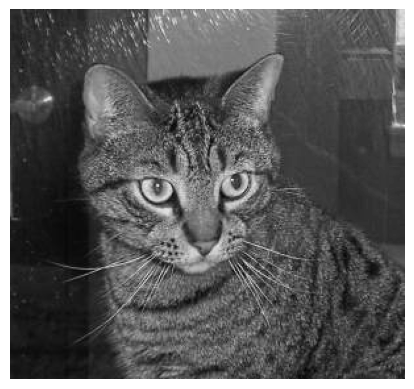

(281, 300)


In [127]:
img_array = cv2.imread(os.path.join(CATS, '1.jpg'))
img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.axis('off') 
plt.show()

print(img.shape)

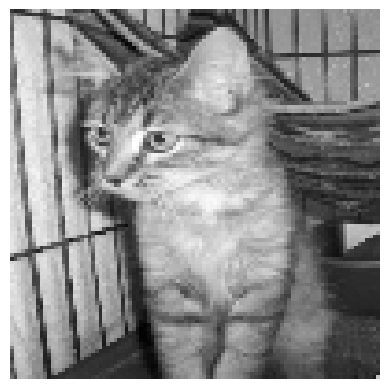

(100, 100)


In [400]:
img_array = cv2.imread(os.path.join(CATS, '2.jpg'))
flag_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(flag_array, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.axis('off') 
plt.show()

print(img.shape)

In [378]:
def create_traning_data():
    samples = []
    for path in CATEGORIES.keys():
        for name in os.listdir(path):
            try:
                updated_path = os.path.join(path, name)
                img_array = cv2.imread(updated_path)
                flag_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                processed_array = cv2.cvtColor(flag_array, cv2.COLOR_BGR2GRAY)
                samples.append([processed_array, CATEGORIES[path]])
            except Exception as e:
                pass
            
    return samples

In [424]:
traning_data = create_traning_data()
len(traning_data)

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


24946

In [428]:
X = []
y = []

random.shuffle(traning_data)

for feature, label in traning_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

## Save data

In [440]:
import pickle

with open('cats_dogs_x_y_data.pkl', 'wb') as f:
    pickle.dump((X, y), f)